<a href="https://colab.research.google.com/github/alaguilarunal/gibb_sampler/blob/main/rack_gibbs_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import scipy.sparse as sp
from random import choice, randint
from collections.abc import Callable

from ipywidgets import interact, widgets

In [ ]:
class GibbsNode:
    __slots__ = ('val', 'neighbors', 'neighbors_val_count')

    def __init__(self, val: int, val_cases: int) -> None:
        self.val = val
        self.neighbors = []
        self.neighbors_val_count = [0] * val_cases

    def inteconnect_neighbor(self, neighbor: 'GibbsNode') -> None:
        self.neighbors.append(neighbor)
        neighbor.neighbors.append(self)
        self.add_val_count(neighbor.val)
        neighbor.add_val_count(self.val)

    def add_val_count(self, val: int) -> None:
        self.neighbors_val_count[val] += 1

    def subtract_val_count(self, val: int) -> None:
        self.neighbors_val_count[val] -= 1

    def update_val(self, upd_func: Callable[[list[int]], int]) -> None:
        old_val = self.val
        neighbors_val_count = self.neighbors_val_count
        new_val = upd_func(neighbors_val_count)
        for neighbor in self.neighbors:
            neighbor.subtract_val_count(old_val)
            neighbor.add_val_count(new_val)
        self.val = new_val


In [ ]:
# Basic option, very fast representation of current state of the chain
# use it for histogram
class GibbsRack:
    __slots__ = ('gibbs_nodes', 'upd_func', 'sqr_size')

    def __init__(self, sqr_size: int, val_cases: int, upd_func: Callable[[list[int]], int]) -> None:
        self.sqr_size = sqr_size
        self.gibbs_nodes = [GibbsNode(0, val_cases) for _ in range(sqr_size * sqr_size)]
        self.neighbors_connect()
        self.upd_func = upd_func

    def neighbors_connect(self) -> None:
        sqr_size = self.sqr_size
        gibbs_nodes = self.gibbs_nodes
        len_nodes = len(gibbs_nodes)

        #column interconnect
        for i in range(0, len_nodes - sqr_size):
            gibbs_nodes[i].inteconnect_neighbor(gibbs_nodes[i + sqr_size])

        #row interconnect
        for i in range(0, len_nodes, sqr_size):
            for j in range (sqr_size - 1):
                gibbs_nodes[i + j].inteconnect_neighbor(gibbs_nodes[i + j + 1])

    def markov_step(self) -> None:
        a = choice(self.gibbs_nodes)
        a.update_val(self.upd_func)

    def matrix_repr(self) -> np.ndarray:
        list_repr = [node.val for node in self.gibbs_nodes]
        return np.reshape(list_repr, (self.sqr_size, self.sqr_size))

    def get_col_map(self):
        colors = len(self.gibbs_nodes[0].neighbors_val_count)
        if colors == 2:
            return plt.colormaps['binary']
        return plt.colormaps['tab20'].resampled(colors)

# Fastest class when need to memoize a big number of steps of the chain
# Breaks when have too big chains
class MemoGibbsRack(GibbsRack):
    __slots__ = ('memoized_steps', 'memoized_state')

    def __init__(self, sqr_size: int, val_cases: int, upd_func: Callable[[list[int]], int]) -> None:
        super().__init__(sqr_size, val_cases, upd_func)
        self.memoized_steps = []
        self.memoized_state = [np.zeros((sqr_size, sqr_size), dtype=int)]

    def markov_step(self) -> None:
        i, j = np.random.randint(0, self.sqr_size, size=2)
        node = self.gibbs_nodes[i * self.sqr_size + j]
        node.update_val(self.upd_func)
        val = node.val
        self.memoized_steps.append((val, i, j))

    def memo_matrix_repr(self, n: int) -> np.ndarray:
        while len(self.memoized_state) - 1 < n:
            val, i, j = self.memoized_steps.pop(0)
            new_state = np.copy(self.memoized_state[-1])
            new_state[i, j] = val
            self.memoized_state.append(new_state)
        return self.memoized_state[-1]

# Best option when you need to memoize steps in a chain with very big representations
class SparseGibbsRack(GibbsRack):
    __slots__ = ('memoized_delta')

    def __init__(self, sqr_size: int, val_cases: int, upd_func: Callable[[list[int]], int]) -> None:
        super().__init__(sqr_size, val_cases, upd_func)
        self.memoized_delta = [sp.coo_matrix((sqr_size, sqr_size), dtype=int).tocsr()]

    def markov_step(self) -> None:
        i, j = np.random.randint(0, self.sqr_size, size=2)
        node = self.gibbs_nodes[i * self.sqr_size + j]
        old_val = node.val
        node.update_val(self.upd_func)
        new_val = node.val
        delta = new_val - old_val
        delta_matrix = sp.coo_matrix(([delta], ([i], [j])), shape=(self.sqr_size, self.sqr_size)).tocsr()
        self.memoized_delta.append(delta_matrix)

    def sparse_matrix_repr(self, n: int) -> np.ndarray:
        sum_matrix = self.memoized_delta[0]
        for i in range(0, n + 1):
            sum_matrix = sum_matrix + self.memoized_delta[i]
        return sum_matrix.toarray()

In [ ]:
def hardcore_upd(neighbors_val_count: list[int]) -> int:
    tails = randint(0, 1)
    if tails:
        return not neighbors_val_count[1]
    return 0

def qcoloring_upd(neighbors_val_count: list[int]) -> int:
    possible_colors = [i for i, x in enumerate(neighbors_val_count) if not x]
    return choice(possible_colors)


In [ ]:
def rack_repr(data: np.ndarray, rack: GibbsRack,time):
    plot = sns.heatmap(data, linewidths=1, linecolor='black', square=True, cmap=rack.get_col_map(), cbar=False)
    plot.set(xticks=[], yticks=[], xlabel='', ylabel='',title=f"Configuración para el tiempo {time}")
    #plt.show()
    return plot

def rack_vid(name:str, data_list: list[np.ndarray], rack:GibbsRack) -> None:
    if os.path.exists("./temp_img") == False:
      os.mkdir("./temp_img")
    for i in range(len(data_list)):
        data = data_list[i]
        plt.imsave(f'./temp_img/img{i}.png', data, cmap=rack.get_col_map())
    os.system(f'ffmpeg -framerate 20 -i ./temp_img/img%d.png -vcodec mpeg4 -y {name}.mp4')


# **Primera parte:** algoritmo Gibss sampler

Notas:



1.   Al finalizar la simulación se genera un video de muy baja resolución que permite visualizar las configuraciones en el transcurso del tiempo (por defecto no se genera a menos que se establezca la variable **save_video=True**). El objetivo de generar el video a una calidad muy pobre, es el de garantizar tiempos relativamente cortos para la creación del video cuando se configura un tiempo de simulación muy largo.

2. El video se guarda en formato MP4 en la ruta predefinida para el proyecto en google colab.

3.   Para la visualización de las configuraciones generadas durante la simulación, siga las instrucciones de la celda abajo del histograma generado



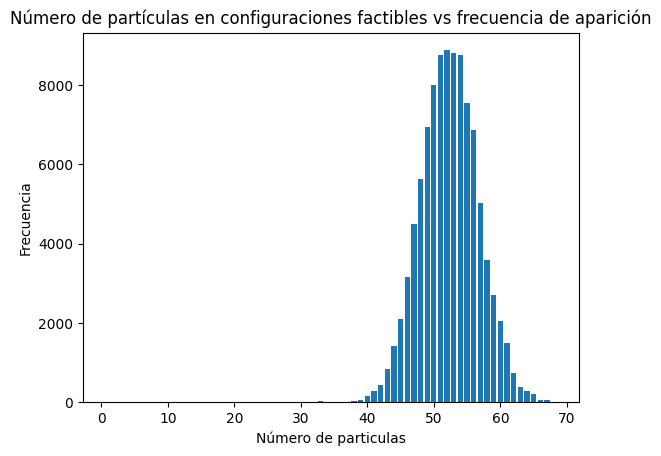

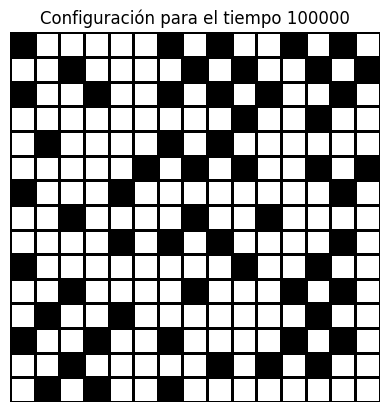

In [ ]:
rack_size=15 # n=rack_size for nxn rack
n_time=100000 #simulation time
particles={}
save_video=False

hardcore_sim = GibbsRack(rack_size, 2, hardcore_upd)
x_i = hardcore_sim.matrix_repr()
x = [x_i]
for i in range(int(n_time)):
    hardcore_sim.markov_step()
    x_i = hardcore_sim.matrix_repr()
    n_particles = np.sum(x_i)
    if n_particles in particles:
      particles[n_particles] = particles[n_particles] + 1
    else:
      particles[n_particles] = 1

    x.append(x_i)
n_p=particles.keys()
freq=particles.values()

plt.bar(n_p,freq)
plt.title("Número de partículas en configuraciones factibles vs frecuencia de aparición")
plt.xlabel("Número de particulas")
plt.ylabel("Frecuencia")
plt.show()

rack_repr(x[-1],hardcore_sim,len(x)-1)
plt.show()
#Creates a very poor quality video of n_i times of simulation
if save_video:
  rack_vid("hard", x, hardcore_sim)



Una vez finalizada la simulacón, ejecute la siguiente celda para visualizar el slider que le permitirá mostrar las configuraciones en el instante t seleccionado.

In [ ]:
def show_hard_core(index):
    plot2 = sns.heatmap(x[index], linewidths=1, linecolor='black', square=True, cmap=hardcore_sim.get_col_map(), cbar=False)
    plot2.set(xticks=[], yticks=[], xlabel='', ylabel='',title=f"Configuracion para el tiempo {index}")
    plt.show()

interact(lambda index:show_hard_core(index), index=widgets.IntSlider(min=0, max=len(x)-1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=100000), Output()),…

<function __main__.<lambda>(index)>

# **Segunda parte:** q-coloraciones

Notas:



1.   Al finalizar la simulación se genera un video con el cambio en la rejilla durante el tiempo. En este caso, que si es necesario la visulización de los colores, la construcción del video es bastante demorada. Como referencia, para un simulación de **500 iteraciones** el renderizado del video puede tomar 1.8 minutos.

2. El video se guarda en formato MP4 (animacion.mp4) en la ruta predefinida para el proyecto en google colab.

3. para tiempos de simulación grandes, establezca la variable **save_video=False**, de lo contrario, el tiempo de ejecución dependerá del tiempo de procesamiento del video.

3.   Para la visualización de las configuraciones generadas durante la simulación, siga las instrucciones de la celda abajo del histograma generado

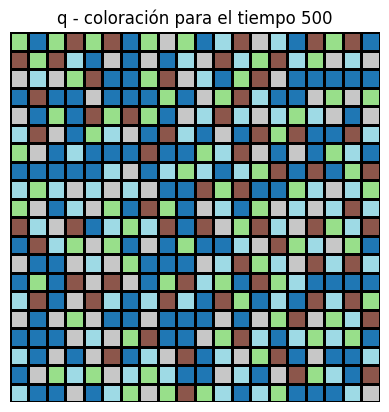

In [ ]:
rack_size=20 # n=rack_size for nxn rack
n_time=500 #simulation time
n_colors=5

save_video=False
colors={}

qcoloring_sim = GibbsRack(rack_size, n_colors, qcoloring_upd)
y_i=qcoloring_sim.matrix_repr()
y = [y_i]

for _ in range(n_time):
    qcoloring_sim.markov_step()
    y_i=qcoloring_sim.matrix_repr()
    #print(f"-----\n",np.unique(y_i))
    for color in np.unique(y_i):
      if color in colors:
        colors[color]=colors[color]+1
      else:
        colors[color]=1
    y.append(y_i)

#y = y[:1000]

#---histograma
"""fig = plt.figure()
ax =  plt.axes()
n_c=colors.keys()
freq=colors.values()

plt.bar(n_c,freq)
plt.title("Número de partículas en configuraciones factibles vs frecuencia de aparición")
plt.xlabel("Colores")
plt.ylabel("Frecuencia")
plt.show()
plt.close()"""

def update(frame):
    ax.clear()
    plot = sns.heatmap(y[frame], ax=ax, linewidths=1, linecolor='black', square=True, cmap=qcoloring_sim.get_col_map(), cbar=False)
    return plot

def show_rank_qcolor(index):
    plt.clf()
    plot2 = sns.heatmap(y[index], linewidths=1, linecolor='black', square=True, cmap=qcoloring_sim.get_col_map(), cbar=False)
    plot2.set(xticks=[], yticks=[], xlabel='', ylabel='',title=f"q - coloración para el tiempo {len(y)-1 if index==-1 else index}")
    plt.show()

if save_video:
  fig = plt.figure()
  ax =  plt.axes()
  ani = FuncAnimation(fig, update, frames=len(y), interval=100)
  ani.save('animacion.mp4', writer='ffmpeg')

show_rank_qcolor(-1)


Una vez finalizada la simulacón, ejecute la siguiente celda para visualizar el slider que le permitirá mostrar las configuraciones en el instante t seleccionado.

In [ ]:
interact(lambda index:show_rank_qcolor(index),index=widgets.IntSlider(min=0, max=len(y)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=500), Output()), _d…

<function __main__.<lambda>(index)>

# **Análisis**


Para el algoritmo Gibbs Sampler, los parámetros principales que podrían variarse son:

1. **Tamaño de la Rejilla (o cantidad de variables):** Este parámetro afectará la complejidad del problema y la dimensionalidad del espacio de búsqueda. Un aumento en el tamaño de la rejilla podría llevar a una distribución más dispersa de las configuraciones, y potencialmente a un tiempo de convergencia más largo.

2. **Número de Iteraciones:** El número de iteraciones del algoritmo puede influir en la calidad de las muestras generadas y en la convergencia del algoritmo hacia la distribución estacionaria. Un mayor número de iteraciones tiende a mejorar la convergencia, pero también puede aumentar el tiempo de ejecución.

3. **Número de Colores (en el caso de q-coloraciones):** En el contexto de q-coloraciones, el número de colores disponibles afectará la distribución de las configuraciones resultantes. Un mayor número de colores puede permitir una mayor diversidad en las configuraciones, mientras que un número menor de colores podría limitar las opciones y llevar a configuraciones más homogéneas.

4. **Tipo de Distribución Inicial:** La distribución inicial de las variables también puede influir en la distribución final. Si la distribución inicial es muy sesgada, podría afectar la velocidad de convergencia y la exploración del espacio de búsqueda.

Al variar estos parámetros, es importante considerar cómo afectarán la convergencia del algoritmo y la exploración del espacio de configuraciones. En general, la distribución esperada será aquella que se aproxime a la distribución estacionaria del sistema, la cual depende de la interacción entre los parámetros y la naturaleza del problema abordado.

Algo adicional que podemos obersvar en el primer histograma, es que este se asemeja a a una distrución normal, esto puede deberse a algunos factores:

- **Convergencia a una distribución normal:** Dadas las reglas de Hardcore y q-coloreo cuando han convergido adecuadamente hacia la distribución estacionaria puede que esta distribución sea normal o tenga características similares a una distribución normal.

- **Central Limit Theorem (Teorema del Límite Central):** El Teorema del Límite Central establece que, bajo ciertas condiciones, la suma de un gran número de variables aleatorias independientes e idénticamente distribuidas (iid) tiende a una distribución normal, independientemente de la distribución original de las variables. Esto significa que incluso si las muestras generadas por el algoritmo de Gibbs Sampler no siguen una distribución normal, la suma de un gran número de estas muestras podría aproximarse a una distribución normal.

En el segundo histograma podemos observar que la distribución es uniforme, pues cada uno de los colores tiene aproximadamente la misma frecuencia de aparicion independientemente de la cantidad de colores y el tamaño de la rejilla.



